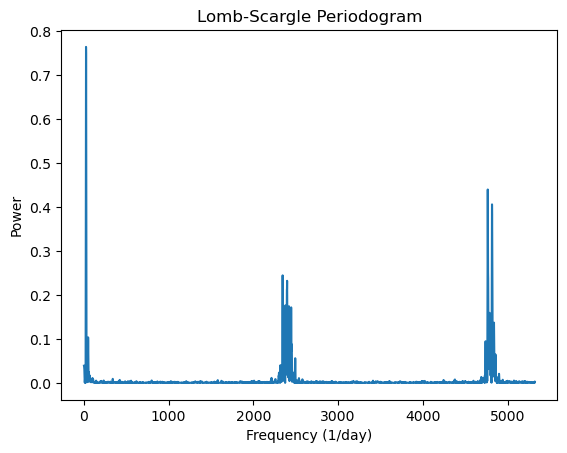

Best frequency (1/day): 25.151945448525034
Omega (rad/day): 158.03433408915495
Best period (days): 0.03975835595089692


In [3]:
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

file_path = "C:\\Users\\PC-01\\Desktop\\astro\\astro_puls.xlsx" #change the file path if needed 

df = pd.read_excel(file_path, sheet_name='Sheet2') # convert ecxcel sheet to a DataFrame, make sure you are on the right sheet
time=df['J.D-2400000'] # extract the time 
m=df['m'] # extract the magnitude
m_error=df['∆m_T'] #extract the error in magnitude

# Apply filter: only keep rows where m < 13.1
#mask = (m > 12.97) & (m < 13.1)
#time_filt = time[mask]
#m_filt = m[mask]
#m_error_filt = m_error[mask]

frequency, power=LombScargle(time, m).autopower()#use the Lomb-Scargle method to get the frequncy

#optinal filter
#frequency, power=LombScargle(time_filt, m_filt).autopower()

# Find best frequency and omega
best_frequency=frequency[np.argmax(power)]  # cycles/day
omega =2*np.pi*best_frequency            # radians/day
# Plot 
plt.plot(frequency, power)
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.show()

# === Output ===
print("Best frequency (1/day):", best_frequency)
print("Omega (rad/day):", omega)
print("Best period (days):", 1 / best_frequency)




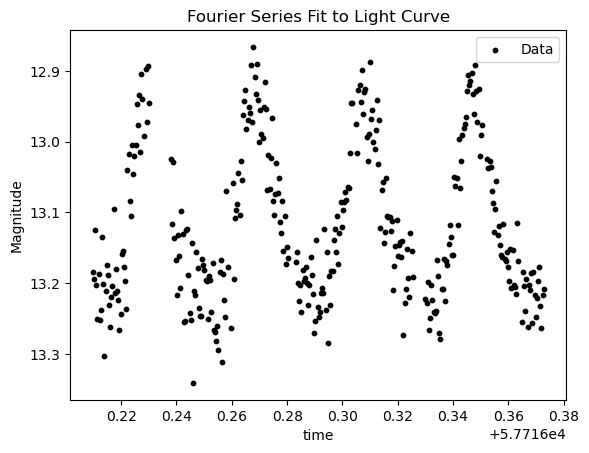

Chi-square: 777.9741912257108
Chi-square_red: 2.274778336917283


In [5]:
def fourier_series(t, *params):
    N = (len(params) - 1) // 2
    result = params[0]  # a0
    for n in range(1, N + 1):
        result+=params[2 * n - 1]*np.cos( n*(omega)*t  )
        result+=params[2 * n]*np.sin(n*(omega)*t)
    return result

# === Choose number of harmonics ===
N = 2 # You can try 2–5 depending on data complexity

# === Initial guess for parameters ===
initial_guess = [np.mean(m)] + [0.1] * (2 * N)

# === Fit ===
params, _ = curve_fit(fourier_series, time, m, p0=initial_guess)

# === Generate fitted curve ===
m_fit = fourier_series(time, *params)

# === Generate  a chi square ===
chi_square = np.sum(((m - m_fit) / m_error) ** 2)  # Chi-square
chi_red = chi_square / (len(m) - len(params))      # Reduced chi-square

# === Plot ===
plt.scatter(time,m,s=10,label='Data',color='black')
#plt.plot(time,m_fit,label=f'Fourier fit (N={N})', color='red')
plt.gca().invert_yaxis()  # For magnitude scale
plt.xlabel('time')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Fourier Series Fit to Light Curve')
plt.show()
print("Chi-square:", chi_square)
print("Chi-square_red:", chi_red)


# === optinal filter ===
#initial_guess = [np.mean(m_filt)] + [0.1] * (2 * N)
#params, _ = curve_fit(fourier_series, time_filt, m_filt, p0=initial_guess)
#m_fit = fourier_series(time_filt, *params)
#chi_square = np.sum(((m_filt - m_fit) / m_error_filt) ** 2)  # Chi-square
#chi_red = chi_square / (len(m_filt) - len(params))      # Reduced chi-square


#plt.scatter(time_filt,m_filt,s=10,label='Data',color='black')
#plt.plot(time_filt,m_fit,label=f'Fourier fit (N={N})', color='red')
#plt.gca().invert_yaxis()  # For magnitude scale
#plt.xlabel('time')
#plt.ylabel('Magnitude')
#plt.legend()
#plt.title('Fourier Series Fit to Light Curve')
#plt.show()
#print("Chi-square:", chi_square)
#print("Chi-square_red:", chi_red)

Initial reduced chi-square: 2.274778336917283


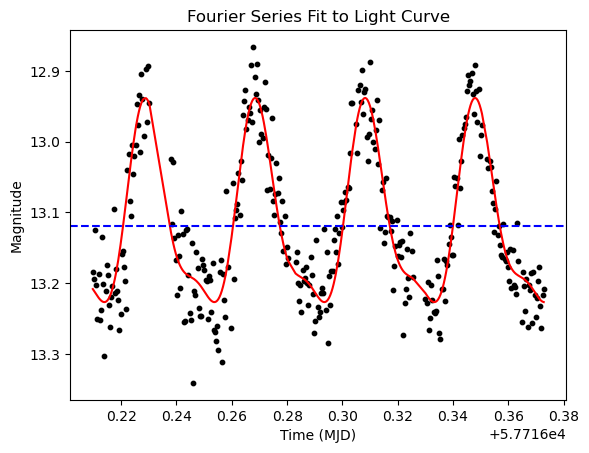

Chi-square: 777.97
Reduced Chi-square: 2.27
Estimated period: 0.954 ± 0.023 hours
the mean magnitude is: 13.12


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Define Fourier series function ===
def fourier_series(t, *params):
    N = (len(params) - 1) // 2
    result = params[0]
    for n in range(1, N + 1):
        result += params[2 * n - 1] * np.cos(n * omega * t)
        result += params[2 * n] * np.sin(n * omega * t)
    return result

# === Fit and compute chi-square ===
def fit_and_chi(omega_trial):
    global omega
    omega = omega_trial
    initial_guess = [np.mean(m)] + [0.1] * (2 * N)
    try:
        params, _ = curve_fit(fourier_series, time, m, p0=initial_guess)
        m_fit = fourier_series(time, *params)
        chi2 = np.sum(((m - m_fit) / m_error) ** 2)
        chi_red = chi2 / (len(m) - len(params))
        return chi_red
    except:
        return np.inf

# === Initial omega value ===
omega_nominal = omega
N = 2  # number of harmonics

# === Initial fit ===
chi_red_nominal = fit_and_chi(omega_nominal)
print("Initial reduced chi-square:", chi_red_nominal)

# === Scan for omega error ===
omega_range = np.linspace(omega_nominal - 10, omega_nominal + 10, 500)
chi_red_vals = np.array([fit_and_chi(w) for w in omega_range])

# Find the omega where chi_red increases by 1
delta = np.abs(chi_red_vals - chi_red_nominal - 1)
idx_error = np.argmin(delta)
omega_error = np.abs(omega_range[idx_error] - omega_nominal)

# === Convert omega error to period error (in hours) ===
P_days = 2 * np.pi / omega_nominal
P_error_days = (2 * np.pi / omega_nominal ** 2) * omega_error
P_hours = P_days * 24
P_error_hours = P_error_days * 24

# === Final fit and plot ===
omega = omega_nominal
initial_guess = [np.mean(m)] + [0.1] * (2 * N)
params, _ = curve_fit(fourier_series, time, m, p0=initial_guess)
m_fit = fourier_series(time, *params)
chi_square = np.sum(((m - m_fit) / m_error) ** 2)
chi_red = chi_square / (len(m) - len(params))

# === Plot fit ===
plt.scatter(time, m, s=10, label='Data', color='black')
plt.plot(time, m_fit, label=f'Fourier fit (N={N})', color='red')
plt.axhline(np.mean(m), color='blue', linestyle='--', label='Mean magnitude')
plt.gca().invert_yaxis()
plt.xlabel('Time (MJD)')
plt.ylabel('Magnitude')
plt.title('Fourier Series Fit to Light Curve')
plt.show()

# === Output ===
print(f"Chi-square: {chi_square:.2f}")
print(f"Reduced Chi-square: {chi_red:.2f}")
print(f"Estimated period: {P_hours:.3f} ± {P_error_hours:.3f} hours")
print(f"the mean magnitude is: {np.mean(m):.2f}")


